# Predictive Maintenance: AI4I 2020
**Goal:** Predict machine failure with high precision and useful recall to reduce unplanned downtime.

In [2]:
# --- Core ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Modeling / split ---
from sklearn.model_selection import train_test_split

# --- Preprocessing ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# --- Metrics / plots ---
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    PrecisionRecallDisplay,
)

# Reproducibility
RANDOM_STATE = 42

# Project paths
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True, parents=True)
ASSETS_DIR = Path("assets"); ASSETS_DIR.mkdir(exist_ok=True, parents=True)

## Data Overview
- Load dataset and verify shape/columns
- Check target balance and missing values

In [3]:
# Load data (place ai4i2020.csv in the data/ folder)
csv_path = DATA_DIR / 'ai4i2020.csv'
assert csv_path.exists(), f"Missing {csv_path}. Download from UCI and place it in data/."
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# --- Basic Data Checks ---

# View column names and dataset dimensions
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nColumns:\n", df.columns.tolist())

# Summary statistics for numeric features
display(df.describe().T.style.background_gradient(cmap="Blues"))

Shape: 10000 rows × 14 columns

Columns:
 ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


,count,mean,std,min,25%,50%,75%,max
UDI,10000.000000,5000.500000,2886.895680,1.000000,2500.750000,5000.500000,7500.250000,10000.000000
Air temperature [K],10000.000000,300.004930,2.000259,295.300000,298.300000,300.100000,301.500000,304.500000
Process temperature [K],10000.000000,310.005560,1.483734,305.700000,308.800000,310.100000,311.100000,313.800000
Rotational speed [rpm],10000.000000,1538.776100,179.284096,1168.000000,1423.000000,1503.000000,1612.000000,2886.000000
Torque [Nm],10000.000000,39.986910,9.968934,3.800000,33.200000,40.100000,46.800000,76.600000
Tool wear [min],10000.000000,107.951000,63.654147,0.000000,53.000000,108.000000,162.000000,253.000000
Machine failure,10000.000000,0.033900,0.180981,0.000000,0.000000,0.000000,0.000000,1.000000
TWF,10000.000000,0.004600,0.067671,0.000000,0.000000,0.000000,0.000000,1.000000
HDF,10000.000000,0.011500,0.106625,0.000000,0.000000,0.000000,0.000000,1.000000
PWF,10000.000000,0.009500,0.097009,0.000000,0.000000,0.000000,0.000000,1.000000


In [5]:
# Define target column (based on dataset description)
target_col = "Machine failure"

# Check class distribution
print("Target distribution (proportion):")
print(df[target_col].value_counts(normalize=True).rename("proportion").round(3))

Target distribution (proportion):
Machine failure
0    0.966
1    0.034
Name: proportion, dtype: float64


In [6]:
# Check for missing values
print("Missing values by column:")
print(df.isna().sum())

Missing values by column:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [25]:
# Label consistency: 'Machine failure' vs OR(TWF,HDF,PWF,OSF,RNF)
flags = ["TWF", "HDF", "PWF", "OSF", "RNF"]
has_subtype = (df[flags].sum(axis=1) > 0).astype(int)

inconsistent_mask = df["Machine failure"].astype(int) != has_subtype
n_inconsistent = int(inconsistent_mask.sum())
n_total = len(df)
pct_inconsistent = 100 * n_inconsistent / n_total

print(f"{n_inconsistent:,} out of {n_total:,} rows "
      f"({pct_inconsistent:.2f}%) where 'Machine failure' != OR(TWF,HDF,PWF,OSF,RNF)")

27 out of 10,000 rows (0.27%) where 'Machine failure' != OR(TWF,HDF,PWF,OSF,RNF)


> **Data quality check:**  
> Verified that the overall `Machine failure` flag aligns with the sub-failure types (`TWF–RNF`).  
> Only 27 out of 10,000 rows showed minor inconsistencies, treated as negligible label noise.


## Feature Engineering
`Product ID` begins with a letter (L/M/H) that encodes product category.
- Extract `Product_Category` from `Product ID`
- Remove leakage columns: `TWF, HDF, PWF, OSF, RNF`

In [7]:
# Extract product category (L/M/H) from 'Product ID' and drop the raw ID
if "Product ID" in df.columns:
    df["Product_Category"] = df["Product ID"].astype(str).str[0]
    df.drop(columns=["Product ID"], inplace=True)

# Quick check
if "Product_Category" in df.columns:
    print("Product_Category counts:")
    print(df["Product_Category"].value_counts(dropna=False))

Product_Category counts:
Product_Category
L    6000
M    2997
H    1003
Name: count, dtype: int64


In [8]:
# --- Features (X) and target (y) ---

# Drop pure row identifiers (keep only those that actually exist)
id_cols = ["UDI"]
id_cols = [c for c in id_cols if c in df.columns]

# Feature columns = everything except target + ids
feature_cols = [c for c in df.columns if c not in [target_col] + id_cols]

# Build X and y (keep X as DataFrame to preserve column names)
X = df[feature_cols]
y = df[target_col].astype(int)

print(f"Target: {target_col}")
print(f"Number of features: {len(feature_cols)} columns")
print("First few features:", feature_cols[:8])


Target: Machine failure
Number of features: 12 columns
First few features: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF']


In [9]:
# Remove failure subtype columns from features to avoid leakage
leak_cols = ["TWF", "HDF", "PWF", "OSF", "RNF"]
leak_cols_present = [c for c in leak_cols if c in feature_cols]
print("Dropping potential leakage columns:", leak_cols_present)

feature_cols = [c for c in feature_cols if c not in leak_cols_present]
X = df[feature_cols]  # refresh X after updating feature_cols

print(f"Final feature count: {len(feature_cols)}")
print("Sample features:", feature_cols[:8])

Dropping potential leakage columns: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Final feature count: 7
Sample features: ['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Product_Category']


## Split & Preprocessing
- Stratified train/test split
- Numerical scaling and categorical one-hot encoding

In [10]:
# Column types
num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)
print(f"Train: {X_train.shape}  |  Test: {X_test.shape}")

Numeric columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Categorical columns: ['Type', 'Product_Category']
Train: (7500, 7)  |  Test: (2500, 7)


In [11]:
# One shared version-safe OneHotEncoder
try:
    ohe_shared = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe_shared = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Logistic Regression: scale numerics + OHE categoricals
preprocess_for_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", ohe_shared, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# Tree models: passthrough numerics + OHE categoricals (no scaling)
preprocess_for_trees = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", ohe_shared, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# Sanity check: verify transformed feature matrix shape
preprocess_for_lr.fit_transform(X_train).shape

(7500, 11)

## Models

### Calibrated Logistic Regression
- `class_weight='balanced'` to handle imbalance
- Platt scaling with cross-validated calibration

In [12]:
# Calibrated Logistic Regression (class-balanced)

logit_pipe = Pipeline([
    ("pre", preprocess_for_lr),
    ("clf", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        solver="liblinear",
        random_state=RANDOM_STATE,
    )),
])

# Version-safe CalibratedClassifierCV
try:
    cal_logit = CalibratedClassifierCV(estimator=logit_pipe, cv=3, method="sigmoid")
except TypeError:
    cal_logit = CalibratedClassifierCV(base_estimator=logit_pipe, cv=3, method="sigmoid")

cal_logit.fit(X_train, y_train)

proba_lr = cal_logit.predict_proba(X_test)[:, 1]
print(
    f"Calibrated Logistic | PR-AUC: {average_precision_score(y_test, proba_lr):.3f} | "
    f"ROC-AUC: {roc_auc_score(y_test, proba_lr):.3f}"
)

Calibrated Logistic | PR-AUC: 0.379 | ROC-AUC: 0.883


### Random Forest (Baseline)
- `class_weight='balanced'`
- Strong non-linear baseline

In [13]:
# Random Forest baseline

rf_pipe = Pipeline([
    ("pre", preprocess_for_trees),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        class_weight="balanced",   # handles imbalance
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
])

rf_pipe.fit(X_train, y_train)
proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

print(
    f"Random Forest | PR-AUC: {average_precision_score(y_test, proba_rf):.3f} | "
    f"ROC-AUC: {roc_auc_score(y_test, proba_rf):.3f}"
)

Random Forest | PR-AUC: 0.761 | ROC-AUC: 0.966


## Evaluation & Curves

### Metrics Summary
- PR-AUC, ROC-AUC, and Recall at 90% Precision

In [26]:
# Recall at 90% Precision

def recall_at_precision(y_true, y_proba, precision_target=0.90):
    p, r, th = precision_recall_curve(y_true, y_proba)
    idx = np.where(p[:-1] >= precision_target)[0]  # align with th (len-1)
    if len(idx) == 0:
        return np.nan, np.nan
    best_local = np.argmax(r[:-1][idx])            # max recall among qualifying points
    i = idx[best_local]
    return float(r[i]), float(th[i])

rec_lr, thr_lr = recall_at_precision(y_test, proba_lr, 0.90)
rec_rf, thr_rf = recall_at_precision(y_test, proba_rf, 0.90)

print(f"Calibrated Logistic: \nRecall at 90% precision = {rec_lr:.3f} (Threshold = {thr_lr:.3f})")
print(f"\nRandom Forest:\nRecall at 90% precision = {rec_rf:.3f} (Threshold = {thr_rf:.3f})")

Calibrated Logistic: 
Recall at 90% precision = 0.129 (Threshold = 0.647)

Random Forest:
Recall at 90% precision = 0.353 (Threshold = 0.580)


In [15]:
summary = pd.DataFrame([
    {"Model": "Calibrated Logistic", "PR-AUC": average_precision_score(y_test, proba_lr),
     "ROC-AUC": roc_auc_score(y_test, proba_lr), "Recall@90%P": rec_lr, "Threshold": thr_lr},
    {"Model": "Random Forest", "PR-AUC": average_precision_score(y_test, proba_rf),
     "ROC-AUC": roc_auc_score(y_test, proba_rf), "Recall@90%P": rec_rf, "Threshold": thr_rf},
]).round(4)

summary


,Model,PR-AUC,ROC-AUC,Recall@90%P,Threshold
0,Calibrated Logistic,0.3793,0.8833,0.1294,0.6475
1,Random Forest,0.7609,0.9664,0.3529,0.5800


In [16]:
summary.to_csv(ASSETS_DIR / "metrics_summary.csv", index=False)

### Metrics Summary @ 90% Precision
- Recalls per model at the fixed operating point, plus uplift (RF − LR).

In [22]:
# fixed operating point (target precision same as above)
P_TARGET = 0.90

# recalls and thresholds computed just above in this cell, e.g.:
# rec_lr,  thr_lr  = recall_at_precision(y_test, proba_lr, P_TARGET)
# rec_rf,  thr_rf  = recall_at_precision(y_test, proba_rf, P_TARGET)

# Compute uplift (Percentage Points)
# If a model can't hit the target precision, recall will be NaN
if pd.isna(rec_lr) or pd.isna(rec_rf):
    uplift_pp = np.nan
    print(f"{int(P_TARGET*100)}% precision: one model could not reach the target (recall is NaN).")
else:
    lr_pct = 100 * rec_lr
    rf_pct = 100 * rec_rf
    uplift_pp = rf_pct - lr_pct
    print(
        f"Recall @ {int(P_TARGET*100)}%P — "
        f"Calibrated Logistic: {lr_pct:.1f}% | Random Forest: {rf_pct:.1f}% | Uplift: {uplift_pp:.1f} pp"
    )

# optional: log thresholds as raw probabilities
print(f"\nThresholds — LR: {thr_lr:.4f} | RF: {thr_rf:.4f}")

# small CSV the README can reference
pd.DataFrame([{
    "precision_target": P_TARGET,
    "calibrated_logistic_recall": rec_lr,
    "random_forest_recall": rec_rf,
    "uplift_pp": uplift_pp
}]).to_csv(ASSETS_DIR / "operating_point_uplift.csv", index=False)

Recall @ 90%P — Calibrated Logistic: 12.9% | Random Forest: 35.3% | Uplift: 22.4 pp

Thresholds — LR: 0.6475 | RF: 0.5800


### Precision–Recall Curves
- Combined comparison plus individual curves

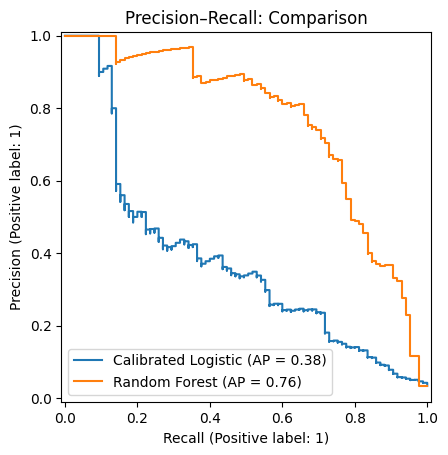

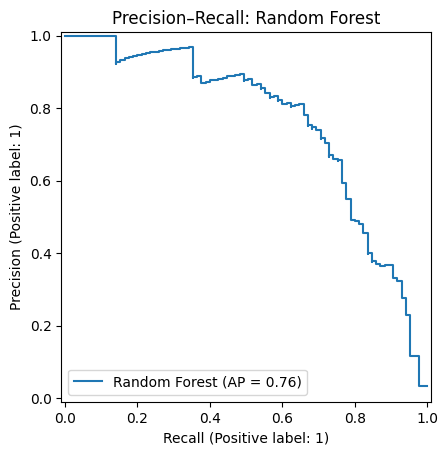

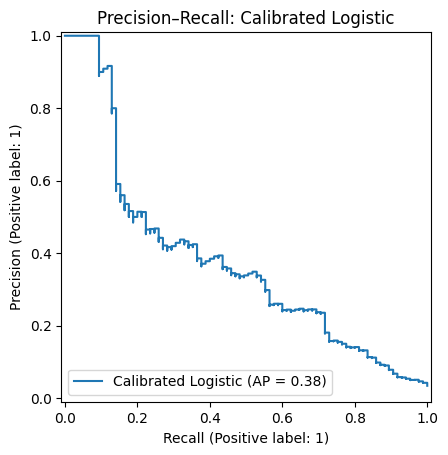

In [18]:
# Precision–Recall curves

# Combined comparison
ax = plt.gca()
PrecisionRecallDisplay.from_predictions(y_test, proba_lr, name="Calibrated Logistic", ax=ax)
PrecisionRecallDisplay.from_predictions(y_test, proba_rf, name="Random Forest", ax=ax)
plt.title("Precision–Recall: Comparison")
plt.savefig(ASSETS_DIR / "pr_curve_comparison.png", dpi=160, bbox_inches="tight")
plt.show()

# Individual: Random Forest
disp = PrecisionRecallDisplay.from_predictions(y_test, proba_rf, name="Random Forest")
plt.title("Precision–Recall: Random Forest")
plt.savefig(ASSETS_DIR / "pr_curve_randomforest.png", dpi=160, bbox_inches="tight")
plt.show()

# Individual: Calibrated Logistic
disp = PrecisionRecallDisplay.from_predictions(y_test, proba_lr, name="Calibrated Logistic")
plt.title("Precision–Recall: Calibrated Logistic")
plt.savefig(ASSETS_DIR / "pr_curve_logistic.png", dpi=160, bbox_inches="tight")
plt.show()


## Feature Importance

In [19]:
# Random Forest top features
importances = rf_pipe.named_steps["clf"].feature_importances_
try:
    feature_names = rf_pipe.named_steps["pre"].get_feature_names_out()
except AttributeError:
    ohe = rf_pipe.named_steps["pre"].named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) else np.array([])
    feature_names = np.concatenate([np.array(num_cols), cat_names])

top20 = (pd.Series(importances, index=feature_names)
           .sort_values(ascending=False)
           .head(20)
           .reset_index())
top20.columns = ["Feature", "Importance"]
top20.round(4)

,Feature,Importance
0,Torque [Nm],0.3158
1,Rotational speed [rpm],0.2931
2,Tool wear [min],0.2006
3,Air temperature [K],0.0993
4,Process temperature [K],0.0700
5,Type_L,0.0053
6,Product_Category_L,0.0043
7,Product_Category_M,0.0036
8,Type_M,0.0032
9,Type_H,0.0024


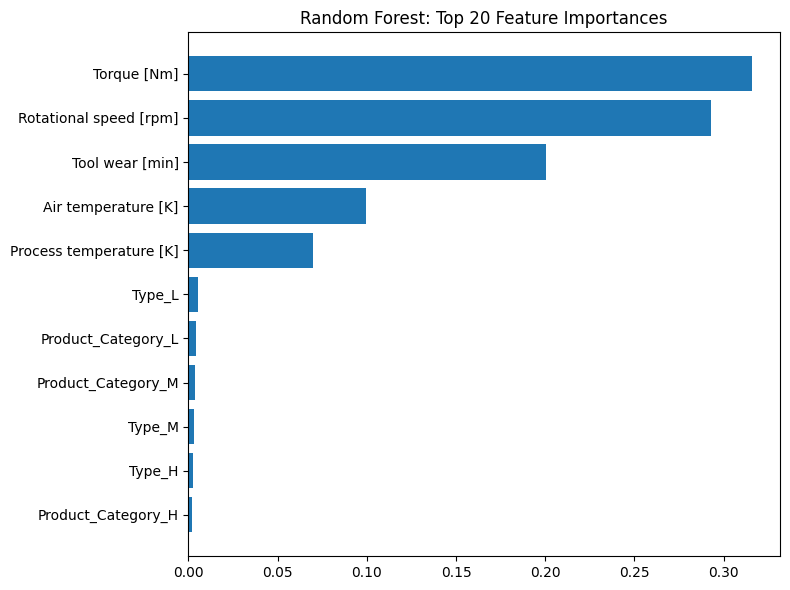

In [20]:
#Random Forest top features plot

top20.to_csv(ASSETS_DIR / "rf_feature_importances_top20.csv", index=False)
plt.figure(figsize=(8, 6))
plt.barh(top20["Feature"][::-1], top20["Importance"][::-1])
plt.title("Random Forest: Top 20 Feature Importances")
plt.tight_layout()
plt.savefig(ASSETS_DIR / "feature_importances_rf.png", dpi=160, bbox_inches="tight")
plt.show()

### Feature Importance Insights

The Random Forest identifies **Torque**, **Rotational speed**, and **Tool wear** as dominant predictors of failure, aligning with real-world engineering intuition.  
Environmental factors such as **air** and **process temperature** also contribute, though less strongly.  
Categorical features (machine type and product category) have smaller impacts, mainly capturing contextual variation between equipment types.

## Conclusion
Random Forest achieved stronger ranking power (PR-AUC ≈ 0.76, ROC-AUC ≈ 0.97) and higher recall at a fixed 90% precision than the calibrated logistic model. Logistic regression remains useful for well-calibrated probabilities and interpretability. Model choice depends on the interpretability vs. performance trade-off.